In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


class DataSimulator:
    def __init__(self, n_samples=100, linear_coef=1, quad_coef=0.1, base_noise_std=1,
                 noise_increase_func=np.ones_like, xmin=0, xmax=10, ymin=0, ymax=20, random_state=None):
        self.n_samples = n_samples
        self.linear_coef = linear_coef
        self.quad_coef = quad_coef
        self.base_noise_std = base_noise_std
        self.noise_increase_func = noise_increase_func
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.random_state = random_state
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def generate_data(self, filter=True):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Simulate data
        X = np.random.randn(self.n_samples, 1) + 5
        noise = np.random.randn(self.n_samples) * self.base_noise_std * self.noise_increase_func(X.squeeze())
        y = self.quad_coef * X.squeeze()**2 + self.linear_coef * X.squeeze() + noise

        # Filter data if needed
        if filter:
            mask = (X.squeeze() >= self.xmin) & (X.squeeze() <= self.xmax) & (y >= self.ymin) & (y <= self.ymax)
            X = X[mask]
            y = y[mask]

        print(f"Number of samples: {len(X)}")
        self.X_train = X
        self.y_train = y

        return self.X_train, self.y_train
    
    def split_data(self, test_size=0.2):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        # Make sure data is generated before split
        if self.X_train is None or self.y_train is None:
            self.generate_data()

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_train, self.y_train, test_size=test_size, random_state=self.random_state
        )
        
        # Assign the split data to class variables
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        return self.X_train, self.X_test, self.y_train, self.y_test

class DataPlotter:
    @staticmethod
    def scatter_plot(X, y):
        plt.scatter(X, y, color='blue', label='Training data')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('Scatter Plot of X vs y')
        plt.legend()
        plt.show()

class ConformalPredictor:
    def __init__(self, model, alpha=0.05, ymin=0, ymax=20):
        self.model = model
        self.alpha = alpha
        self.ymin = 0
        self.ymax = 20
        self.lower_bound = None
        self.upper_bound = None

    @staticmethod
    def calculate_nonconformity_scores(X, y, model):
        y_pred = model.predict(X)
        return np.abs(y - y_pred)

    def predict_interval(self, X_train, y_train, X_new, y_range):
        for i, y_hypothesis in enumerate(y_range):
            # Augment the training data with the new point and hypothesized outcome
            X_augmented = np.vstack([X_train, X_new])
            y_augmented = np.append(y_train, y_hypothesis)

            # Refit the model on the augmented data
            self.model.fit(X_augmented, y_augmented)

            # Calculate the nonconformity scores for the augmented data
            augmented_scores = self.calculate_nonconformity_scores(X_augmented, y_augmented, self.model)
            # Number of scores
            n = len(augmented_scores) - 1

            # Calculate the conformal quantile
            conformal_quantile = np.quantile(augmented_scores[:-1], min(1, (1 - self.alpha/2) * (1 + 1/n)), method='higher')

            # Get the nonconformity score for predicted y
            y_hypothesis_score = augmented_scores[-1]

            # Update the bounds of the interval
            if y_hypothesis_score <= conformal_quantile:
                if self.lower_bound is None:
                    self.lower_bound = y_hypothesis
                self.upper_bound = y_hypothesis

        return self.lower_bound, self.upper_bound
    
    def test_coverage(self, X_train, y_train, X_test, y_test, y_range):
        coverage_count = 0
        for x_new, y_true in zip(X_test, y_test):
            lower_bound, upper_bound = self.predict_interval(X_train, y_train, np.array([x_new]), y_range)
            if lower_bound <= y_true <= upper_bound:
                coverage_count += 1
        return coverage_count / len(X_test)

In [2]:
# Set the data parameters
n_samples=5000
linear_coef=1
quad_coef=0
base_noise_std=0.5
noise_increase_func=np.sqrt
filter = True
xmin=0
xmax=10
ymin=0
ymax=20
random_state=0

simulator = DataSimulator(n_samples=n_samples, linear_coef=linear_coef, quad_coef=quad_coef, base_noise_std=base_noise_std,
                          noise_increase_func=noise_increase_func, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, random_state=random_state)

# Perform a train-test split
X_train, X_test, y_train, y_test = simulator.split_data(test_size=0.2)

# Set the ACI configurations
# Initialize the linear regression model
model = LinearRegression()

# Initialize conformal predictor
conformal_predictor = ConformalPredictor(model=model, alpha=0.05)

Number of samples: 5000


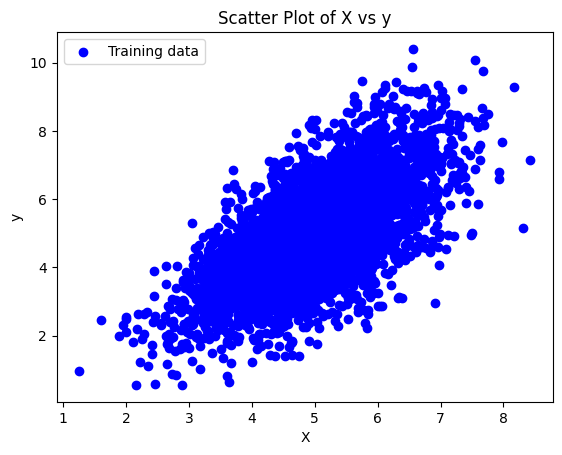

In [3]:
# Plot the data
plotter = DataPlotter()
plotter.scatter_plot(X_train, y_train)

In [4]:
# New data point for which we want the prediction interval
X_new = np.array([[5]])
# Range of possible y values
y_range = np.linspace(simulator.ymin, simulator.ymax, 1000)

# Calculate conformal prediction interval
lower_bound, upper_bound = conformal_predictor.predict_interval(X_train, y_train, X_new, y_range)

# Print the conformal prediction interval
print(f"Conformal prediction interval for the new data point at X_new={X_new[0][0]}: [{lower_bound}, {upper_bound}]")

Conformal prediction interval for the new data point at X_new=5: [2.4024024024024024, 7.5675675675675675]


In [5]:
# Test the real coverage probability
coverage_probability = conformal_predictor.test_coverage(X_train, y_train, X_test, y_test, y_range)
print(coverage_probability)

0.96


In [6]:
class ACI:
    def __init__(self, X, y, ymin=0, ymax=20, model=LinearRegression(), predictor = ConformalPredictor, alpha=0.05, gamma = 0.1):
        self.X = X
        self.y = y
        self.ymin = ymin
        self.ymax = ymax
        self.model = model
        self.predictor = predictor
        self.alpha = alpha
        self.gamma = gamma
        self.intervals = []
        self.coverage = []
        self.alpha_tilde = [1]
        self.current_predictor = None
        
    
    def predict_intervals(self):
        n = self.X.shape[0]
        for i in range(2, n):
            # Update alpha tilde 
            if self.coverage:
                self.alpha_tilde[-1] = self.alpha_tilde[-1] + self.gamma * (self.alpha + self.coverage[-1] - 1)
            self.alpha_tilde[-1] = min(1, max(0, self.alpha_tilde[-1]))
            # New data point for which we want the prediction interval
            X_new = self.X[i]
            # Range of possible y values
            y_range = np.linspace(self.ymin, self.ymax, 1000) 
            # Initialize conformal predictor
            self.current_predictor = self.predictor(model=self.model, alpha=self.alpha_tilde[-1])
            # Generate the predicted interval
            lower_bound, upper_bound = self.current_predictor.predict_interval(self.X[0:i], self.y[0:i], X_new, y_range)
            self.intervals.append([lower_bound, upper_bound])
            if lower_bound <= self.y[i] <= upper_bound:
                coverage = 1
            else:
                coverage = 0
            self.coverage.append(coverage)
            self.alpha_tilde.append(self.alpha_tilde[-1])
            
    def coverage_probability(self):
        return np.mean(self.coverage)
    
    def plot_coverage_probabilities(self):
        # Calculate the cumulative means
        cumulative_means = [np.mean(self.coverage[:i+1]) for i in range(len(self.coverage))]

        # Plot the cumulative means
        plt.plot(cumulative_means, marker='o')
        plt.title('Cumulative Mean of List')
        plt.xlabel('Number of Terms')
        plt.ylabel('Cumulative Mean')
        plt.grid(True)
        plt.show()
    

In [7]:
ACI_model_1 = ACI(X=X_train, y=y_train)
ACI_model_1.predict_intervals()

In [8]:
ACI_model_1.coverage_probability()

0.9452226113056528

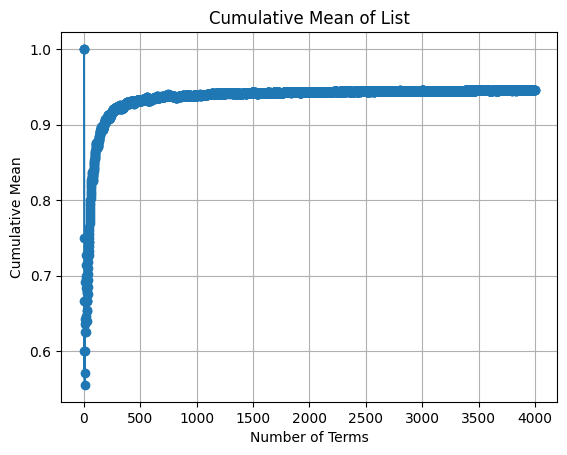

In [9]:
ACI_model_1.plot_coverage_probabilities()

In [10]:
print(len(ACI_model_1.X))
print(len(ACI_model_1.coverage))

4000
3998


In [11]:
# Find indices in list1 where elements are greater than 6
indices = [index for index, element in enumerate(ACI_model_1.X[2:]) if element > 0]

# Use indices to extract the corresponding elements from list2
corresponding_elements = [ACI_model_1.coverage[index] for index in indices]

# Calculate the average of these elements
average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0

print(f"The average of the corresponding items from the second list: {average}")

The average of the corresponding items from the second list: 0.9452226113056528


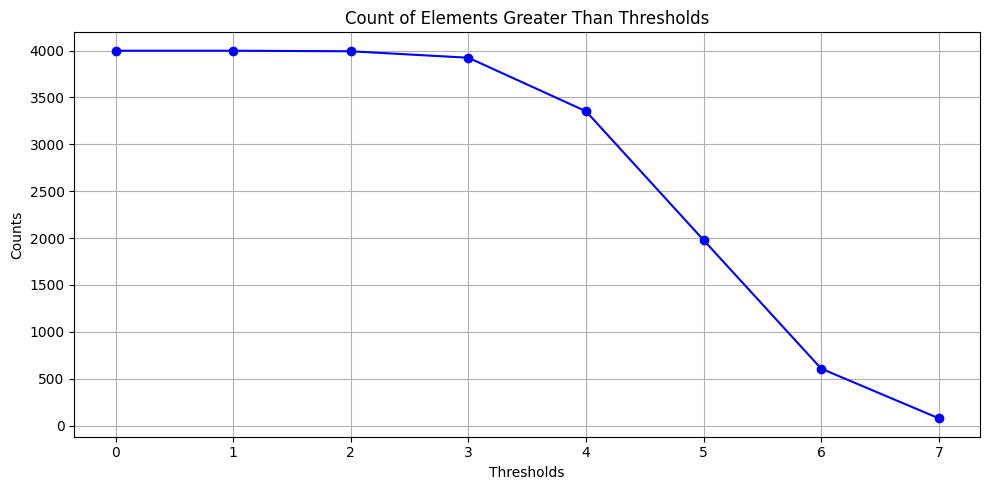

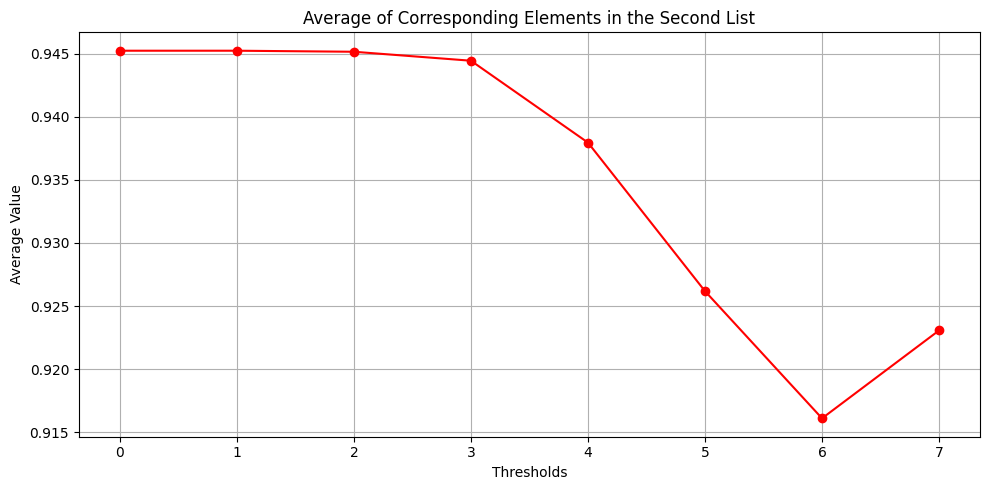

In [12]:
import matplotlib.pyplot as plt

# Your example lists (assuming ACI_model_1.X and ACI_model_1.coverage are your lists)
X = ACI_model_1.X[2:]  # Assuming this is a list-like object with your values
coverage = ACI_model_1.coverage  # And this is your second list

thresholds = [0, 1, 2, 3, 4, 5, 6, 7]
counts = []
averages = []

for threshold in thresholds:
    # Find indices where elements are greater than the current threshold
    indices = [i for i, element in enumerate(X) if element > threshold]
    
    # Use indices to extract the corresponding elements from the second list
    corresponding_elements = [coverage[index] for index in indices]
    
    # Calculate the average of these elements
    average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0
    
    # Store the count of elements and the average for plotting
    counts.append(len(indices))
    averages.append(average)

# Plotting the count of elements greater than thresholds
plt.figure(figsize=(10, 5))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='b')
plt.title('Count of Elements Greater Than Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Plotting the average of corresponding elements in the second list
plt.figure(figsize=(10, 5))
plt.plot(thresholds, averages, marker='o', linestyle='-', color='r')
plt.title('Average of Corresponding Elements in the Second List')
plt.xlabel('Thresholds')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()


In [13]:
class ACI_Binned:
    def __init__(self, X, y, ymin=0, ymax=20, model=LinearRegression(), predictor = ConformalPredictor, alpha=0.05, gamma = 0.1):
        self.X = X
        self.y = y
        self.ymin = ymin
        self.ymax = ymax
        self.model = model
        self.predictor = predictor
        self.alpha = alpha
        self.gamma = gamma
        self.intervals = []
        self.coverage = [[],[]]
        self.alpha_tilde = [[1],[1]]
        self.current_predictor = None
        self.coverage_all = []
        
    
    def predict_intervals(self, cutoff):
        n = self.X.shape[0]
        
        for i in range(2, n):
            # Update alpha tilde 
            if self.X[i] <= cutoff:
                which_list = 0
            else:
                which_list = 1
            if self.coverage[which_list]:
                self.alpha_tilde[which_list][-1] = self.alpha_tilde[which_list][-1] + self.gamma * (self.alpha + self.coverage[which_list][-1] - 1)
            self.alpha_tilde[which_list][-1] = min(1, max(0, self.alpha_tilde[which_list][-1]))
            # New data point for which we want the prediction interval
            X_new = self.X[i]
            # Range of possible y values
            y_range = np.linspace(self.ymin, self.ymax, 1000) 
            # Initialize conformal predictor
            self.current_predictor = self.predictor(model=self.model, alpha=self.alpha_tilde[which_list][-1])
            # Generate the predicted interval
            lower_bound, upper_bound = self.current_predictor.predict_interval(self.X[0:i], self.y[0:i], X_new, y_range)
            self.intervals.append([lower_bound, upper_bound])
            if lower_bound <= self.y[i] <= upper_bound:
                coverage = 1
            else:
                coverage = 0
            self.coverage[which_list].append(coverage)
            self.coverage_all.append(coverage)
            self.alpha_tilde[which_list].append(self.alpha_tilde[which_list][-1])
            
    def coverage_probability(self):
        return np.mean(self.coverage_all)
    
    def plot_coverage_probabilities(self):
        # Calculate the cumulative means
        cumulative_means = [np.mean(self.coverage_all[:i+1]) for i in range(len(self.coverage_all))]

        # Plot the cumulative means
        plt.plot(cumulative_means, marker='o')
        plt.title('Cumulative Mean of List')
        plt.xlabel('Number of Terms')
        plt.ylabel('Cumulative Mean')
        plt.grid(True)
        plt.show()
    

In [14]:
print(len(X_train))
print(len(y_train))

4000
4000


In [15]:
ACI_model_2 = ACI_Binned(X=X_train, y=y_train)
ACI_model_2.predict_intervals(cutoff=4)

In [16]:
ACI_model_2.coverage_probability()

0.9417208604302151

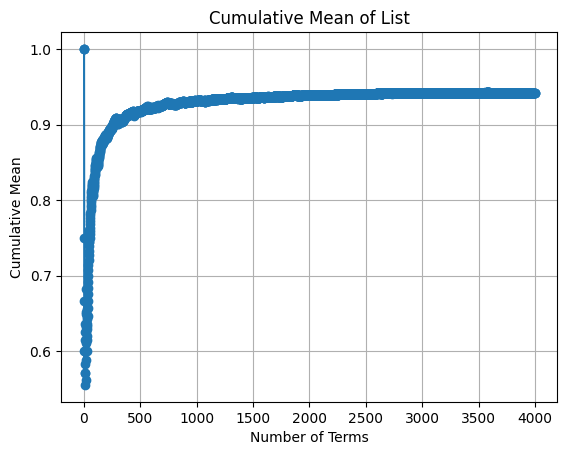

In [17]:
ACI_model_2.plot_coverage_probabilities()

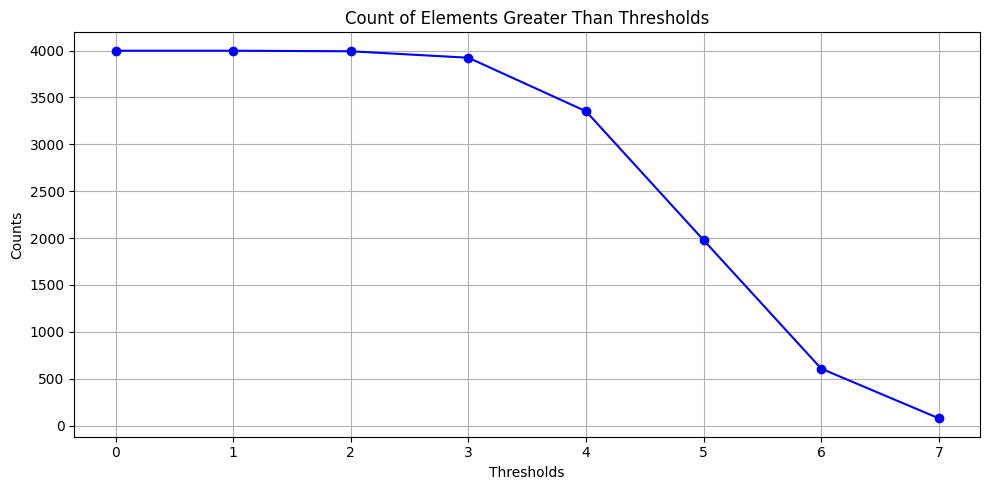

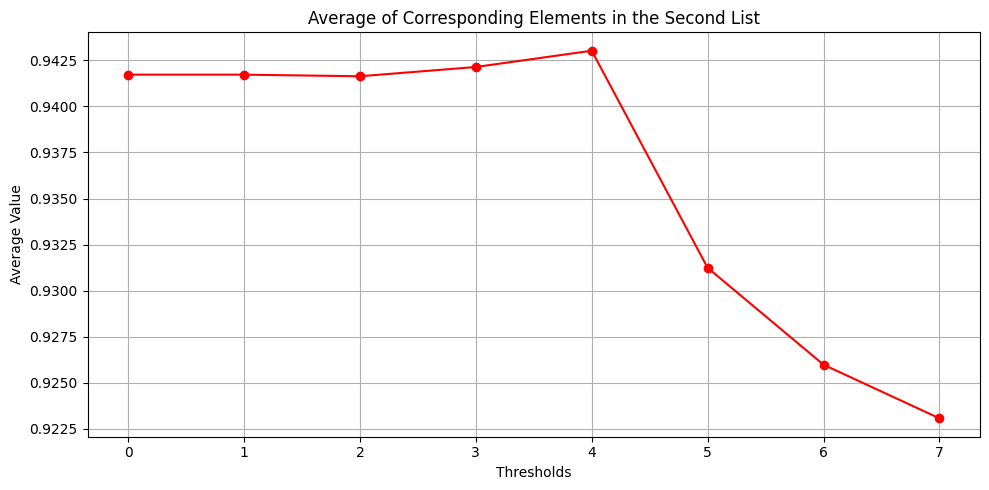

In [18]:
import matplotlib.pyplot as plt

# Your example lists (assuming ACI_model_1.X and ACI_model_1.coverage are your lists)
X = ACI_model_2.X[2:]  # Assuming this is a list-like object with your values
coverage = ACI_model_2.coverage_all  # And this is your second list

thresholds = [0, 1, 2, 3, 4, 5, 6, 7]
counts = []
averages = []

for threshold in thresholds:
    # Find indices where elements are greater than the current threshold
    indices = [i for i, element in enumerate(X) if element > threshold]
    
    # Use indices to extract the corresponding elements from the second list
    corresponding_elements = [coverage[index] for index in indices]
    
    # Calculate the average of these elements
    average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0
    
    # Store the count of elements and the average for plotting
    counts.append(len(indices))
    averages.append(average)

# Plotting the count of elements greater than thresholds
plt.figure(figsize=(10, 5))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='b')
plt.title('Count of Elements Greater Than Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Plotting the average of corresponding elements in the second list
plt.figure(figsize=(10, 5))
plt.plot(thresholds, averages, marker='o', linestyle='-', color='r')
plt.title('Average of Corresponding Elements in the Second List')
plt.xlabel('Thresholds')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()
